
# Proyecto 5 — Chatbot Conversacional Multimodal para Servicio al Cliente (Banco Digital)

**Problema:** Alto volumen de consultas repetitivas (~80%) y necesidad de atención 24/7.  
**Solución:** Chatbot inteligente con **NLU (BERT + clasificación de intenciones + extracción de entidades)**, **gestión de diálogo basada en Transformer con memoria**, **pipeline multimodal (texto + OCR de imágenes)**, **API + interfaz web (Gradio)** y **sistema de evaluación**.

**Datasets:** [Banking77](https://huggingface.co/datasets/banking77)



## 1. Instalación y configuración

In [2]:

# Recomendado ejecutar en Google Colab
!pip -q install --upgrade pip
!pip -q install transformers datasets accelerate evaluate scikit-learn gradio fastapi uvicorn pyngrok python-multipart pillow pytesseract matplotlib
# Opcional: spaCy y modelo liviano en inglés para entidades
!pip -q install spacy && python -m spacy download en_core_web_sm
# Para mostrar gráficas
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.2 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2. Carga del dataset Banking77 (intenciones bancarias)

In [3]:

from datasets import load_dataset

# Cargar el dataset público de intenciones bancarias

ds = load_dataset("banking77")
label_list = ds["train"].features["label"].names
num_labels = len(label_list)
print("Clases:", num_labels)
print("Ejemplo:", ds["train"][0])



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Clases: 77
Ejemplo: {'text': 'I am still waiting on my card?', 'label': 11}


## 3. Preparación de datos (train/validation/test)

In [4]:

from datasets import DatasetDict

# Banking77 ya trae split train/test; creamos validación a partir de train
train_test_valid = ds
train_valid = train_test_valid["train"].train_test_split(test_size=0.1, seed=42)
dataset = DatasetDict({
    "train": train_valid["train"],
    "validation": train_valid["test"],
    "test": train_test_valid["test"]
})
for k in dataset:
    print(k, len(dataset[k]))


train 9002
validation 1001
test 3080


## 4. Baseline: Embeddings básicos (TF‑IDF) + Clasificación Multiclase (LogisticRegression)

In [5]:

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd

# Convertimos a DataFrame para facilidad
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
val_texts = dataset["validation"]["text"]
val_labels = dataset["validation"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=40000)
X_train = tfidf.fit_transform(train_texts)
X_val = tfidf.transform(val_texts)
X_test = tfidf.transform(test_texts)

clf = LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="auto")
clf.fit(X_train, train_labels)
val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)

print("Baseline (TF‑IDF + LR)")
print("Valid Accuracy:", accuracy_score(val_labels, val_pred))
print("Valid Macro-F1:", f1_score(val_labels, val_pred, average="macro"))
print("Test  Accuracy:", accuracy_score(test_labels, test_pred))
print("Test  Macro-F1:", f1_score(test_labels, test_pred, average="macro"))

# Matriz de confusión (conjunto de prueba)
cm = confusion_matrix(test_labels, test_pred, labels=list(range(num_labels)))
cm_df = pd.DataFrame(cm, index=label_list, columns=label_list)
print("Matriz de confusión (test) -> usando las 77 etiquetas (se muestra shape):", cm_df.shape)

# Mostrar top‑5 intenciones del baseline (por probabilidad) para una consulta ejemplo
def baseline_topk(query, k=5):
    probs = clf.predict_proba(tfidf.transform([query]))[0]
    idx = np.argsort(probs)[::-1][:k]
    return [(label_list[i], float(probs[i])) for i in idx]

print("Ejemplo baseline_topk('I lost my card'):", baseline_topk("I lost my card"))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline (TF‑IDF + LR)
Valid Accuracy: 0.8441558441558441
Valid Macro-F1: 0.8345381793947784
Test  Accuracy: 0.8457792207792207
Test  Macro-F1: 0.8438274386981509
Matriz de confusión (test) -> usando las 77 etiquetas (se muestra shape): (77, 77)
Ejemplo baseline_topk('I lost my card'): [('lost_or_stolen_card', 0.6277050848340048), ('card_linking', 0.04402040729623845), ('card_arrival', 0.031111895080665496), ('card_not_working', 0.028101273517084673), ('lost_or_stolen_phone', 0.021362291893837426)]


## 5. NLU Avanzado: Fine‑tuning de BERT (transformers Trainer)

In [6]:
import evaluate
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized = dataset.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

args = TrainingArguments(
    output_dir="bert-banking77",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
print("Evaluación (validation):", trainer.evaluate())

# Función de inferencia con BERT
import torch
id2label = {i:l for i,l in enumerate(label_list)}
def bert_infer(text: str, topk:int=5):
    enc = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        out = model(**enc)
        probs = out.logits.softmax(-1)[0].cpu().numpy()
    idx = np.argsort(probs)[::-1][:topk]
    return [(id2label[i], float(probs[i])) for i in idx]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4087924376.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,2.611800,2.383540,0.666334,0.596494
2,1.884200,1.814274,0.758242,0.715189


Evaluación (validation): {'eval_loss': 1.8142735958099365, 'eval_accuracy': 0.7582417582417582, 'eval_macro_f1': 0.7151890077722011, 'eval_runtime': 156.4837, 'eval_samples_per_second': 6.397, 'eval_steps_per_second': 0.204, 'epoch': 2.0}


## 6. Extracción de Entidades (ligera)

In [7]:

import re, spacy
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    nlp = None
    print("spaCy no disponible; se usarán reglas simples:", e)

# Reglas básicas (IBAN, montos, tarjetas, fechas simples)
patterns = {
    "iban": re.compile(r"\b[A-Z]{2}\d{2}[A-Z0-9]{11,30}\b"),
    "card": re.compile(r"\b(?:\d[ -]*?){13,19}\b"),
    "amount": re.compile(r"\$?\b\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b"),
}

def extract_entities(text: str):
    ents = []
    # Reglas
    for name, pat in patterns.items():
        for m in pat.finditer(text):
            ents.append({"label": name.upper(), "text": m.group()})
    # spaCy (si está)
    if nlp is not None:
        doc = nlp(text)
        for e in doc.ents:
            ents.append({"label": e.label_, "text": e.text})
    return ents

print(extract_entities("I made a $1,250.00 transfer to IBAN ES91 2100 0418 4502 0005 1332 on 12 May 2024"))


[{'label': 'CARD', 'text': '2100 0418 4502 0005'}, {'label': 'AMOUNT', 'text': '$1,250.00'}, {'label': 'AMOUNT', 'text': '12'}, {'label': 'MONEY', 'text': '1,250.00'}, {'label': 'ORG', 'text': 'IBAN'}, {'label': 'CARDINAL', 'text': '2100'}, {'label': 'DATE', 'text': '0418'}, {'label': 'DATE', 'text': '1332'}, {'label': 'DATE', 'text': '12 May 2024'}]


## 7. Gestión de Diálogo (Transformer con memoria corta)

In [8]:

from transformers import AutoModelForCausalLM, AutoTokenizer as AutoTokCausal
import torch

dlg_model_name = "microsoft/DialoGPT-small"
dlg_tok = AutoTokCausal.from_pretrained(dlg_model_name)
dlg_model = AutoModelForCausalLM.from_pretrained(dlg_model_name)

class MemoryBuffer:
    def __init__(self, max_turns=6):
        self.buffer = []
        self.max_turns = max_turns
    def add(self, speaker, text):
        self.buffer.append((speaker, text))
        self.buffer = self.buffer[-self.max_turns:]
    def as_text(self):
        return "\n".join([f"{s}: {t}" for s,t in self.buffer])

memory = MemoryBuffer()

def dialog_reply(user_text, max_new_tokens=80):
    # Guardamos memoria breve
    memory.add("User", user_text)
    context = memory.as_text() + "\nBot:"
    input_ids = dlg_tok.encode(context, return_tensors="pt")
    with torch.no_grad():
        out_ids = dlg_model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            pad_token_id=dlg_tok.eos_token_id,
            do_sample=True,
            top_p=0.9,
            temperature=0.7
        )
    reply = dlg_tok.decode(out_ids[0], skip_special_tokens=True).split("Bot:")[-1].strip()
    memory.add("Bot", reply)
    return reply

print(dialog_reply("Hello, I lost my card. What should I do?"))


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


You can't lock this dog


## 8. Pipeline Multimodal (OCR con imágenes)

In [9]:

import pytesseract
from PIL import Image
import io

def ocr_image(pil_image: Image.Image) -> str:
    text = pytesseract.image_to_string(pil_image)
    return text

# Ejemplo (sube una imagen en Colab y prueba manualmente)
# from google.colab import files
# up = files.upload()
# img = Image.open(next(iter(up)))
# print(ocr_image(img))


In [10]:
# Actualiza pyngrok
!pip install --upgrade pyngrok

In [11]:
import os

# ⚠️ Usas tu token (el que me diste). Si prefieres, cámbialo antes de ejecutar.
os.environ["NGROK_AUTH_TOKEN"] = "30tccZE47Hfv1TzGnt0B2uqgc6q_2Rr75hXnvLFC7PTPhrsSW"

# Confirmación (no imprime el token)
print("Token seteado en variable de entorno NGROK_AUTH_TOKEN.")


Token seteado en variable de entorno NGROK_AUTH_TOKEN.


In [28]:
from pyngrok import ngrok
import os

token = os.environ.get("NGROK_AUTH_TOKEN")
if not token:
    raise RuntimeError("Falta NGROK_AUTH_TOKEN. Configúralo antes de continuar.")

ngrok.kill() # Kill any existing ngrok processes
ngrok.set_auth_token(token)
# Use port 8081 to match the uvicorn server
public_url = ngrok.connect(8080)
print("🌐 Tu API estará en:", public_url)  # Copia esta URL y úsalas para pruebas (o abre /docs)

🌐 Tu API estará en: NgrokTunnel: "https://45aec66233cb.ngrok-free.app" -> "http://localhost:8080"


In [29]:
# Prueba segura de conexión
try:
    tunnel = ngrok.connect(8000)
    print(f"Conexión exitosa! URL pública: {tunnel.public_url}")
except Exception as e:
    print(f"Error al conectar: {e}")
    print("Verifica que el token sea válido en: https://dashboard.ngrok.com/status/tunnels")

Conexión exitosa! URL pública: https://5baa2d62eaa2.ngrok-free.app


In [30]:
from fastapi import FastAPI, UploadFile, File
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from io import BytesIO
from PIL import Image

app = FastAPI(title="Banking Chatbot API")

# CORS (ajústalo en producción)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class Query(BaseModel):
    text: str
    topk: int = 5

@app.post("/predict_intent")
def api_predict_intent(q: Query):
    # BERT preferente; fallback al baseline si BERT no está disponible
    try:
        top = bert_infer(q.text, topk=q.topk)
    except Exception:
        top = baseline_topk(q.text, k=q.topk)
    return {"intents": [{"label": l, "score": float(s)} for l, s in top]}

@app.post("/extract_entities")
def api_extract_entities(q: Query):
    ents = extract_entities(q.text)
    return {"entities": ents}

@app.post("/chat")
def api_chat(q: Query):
    reply = dialog_reply(q.text)
    return {"reply": reply, "memory": memory.as_text()}

@app.post("/ocr")
async def api_ocr(file: UploadFile = File(...)):
    content = await file.read()
    img = Image.open(BytesIO(content)).convert("RGB")
    text = ocr_image(img)
    ents = extract_entities(text)
    return {"text": text, "entities": ents}


In [32]:
# --- One-cell launcher: FastAPI + nest_asyncio + ngrok (Colab/Jupyter) ---

# (1) Dependencias (si ya las tienes, puedes comentar estas líneas)
!pip -q install fastapi uvicorn pyngrok nest_asyncio

# (2) Imports
import os, threading, time
import nest_asyncio
from pyngrok import ngrok

# (3) Tu app FastAPI debe existir como variable `app`.
#     Si ya la definiste arriba, NO ejecutes este ejemplo.
try:
    app  # noqa: F821
except NameError:
    # --- EJEMPLO (bórralo si ya tienes `app`) ---
    from fastapi import FastAPI
    app = FastAPI(title="Demo API")
    @app.get("/")
    def root():
        return {"status": "ok", "msg": "FastAPI + ngrok listo 🎯"}
    # --- FIN EJEMPLO ---

# (4) Token de ngrok (tómalo de variable de entorno)
#     Si ya configuraste el token antes: usa ese y no lo escribas en claro aquí.
token = os.getenv("NGROK_AUTH_TOKEN", "").strip()
if not token:
    raise RuntimeError(
        "Falta NGROK_AUTH_TOKEN. Configúralo antes, por ejemplo:\n"
        "import os; os.environ['NGROK_AUTH_TOKEN'] = 'TU_TOKEN_AQUI'"
    )

# (5) Limpiar túneles previos y abrir uno nuevo en 8081
ngrok.kill()
ngrok.set_auth_token(token)
public_url = ngrok.connect(8081)
print("🌐 URL pública:", public_url)

# (6) Parchear el event loop de Jupyter/Colab y arrancar Uvicorn en un hilo
nest_asyncio.apply()

def _run_uvicorn():
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8081, log_level="info")

t = threading.Thread(target=_run_uvicorn, daemon=True)
t.start()

# (7) Esperar un momento y mostrar /docs
time.sleep(2)
print("📚 Swagger UI:", f"{public_url}/docs")



🌐 URL pública: NgrokTunnel: "https://a2ec853660ac.ngrok-free.app" -> "http://localhost:8081"


INFO:     Started server process [412]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8081 (Press CTRL+C to quit)


📚 Swagger UI: NgrokTunnel: "https://a2ec853660ac.ngrok-free.app" -> "http://localhost:8081"/docs


In [37]:
import requests

# !!! IMPORTANTE: Pega aquí la URL pública que te dio ngrok en el output del Paso 9 (FastAPI + ngrok launcher)
BASE = "YOUR_NGROK_PUBLIC_URL_HERE"
# Ejemplo: BASE = "https://a2ec853660ac.ngrok-free.app"

try:
    resp = requests.post(f"{BASE}/predict_intent", json={"text": "I lost my card", "topk": 5})
    resp.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    print(resp.status_code, resp.json())
except requests.exceptions.RequestException as e:
    print(f"Error making request: {e}")
    if hasattr(e, 'response') and e.response is not None:
        print(f"Response status code: {e.response.status_code}")
        print(f"Response text: {e.response.text}")
    else:
        print("No response received.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error making request: Invalid URL 'YOUR_NGROK_PUBLIC_URL_HERE/predict_intent': No scheme supplied. Perhaps you meant https://YOUR_NGROK_PUBLIC_URL_HERE/predict_intent?
No response received.


In [38]:
import gradio as gr

def ui_intent(text):
    try:
        top = bert_infer(text, topk=5)
    except Exception:
        top = baseline_topk(text, k=5)
    return "\n".join([f"{i+1}. {l}: {s:.3f}" for i,(l,s) in enumerate(top)])

def ui_entities(text):
    ents = extract_entities(text)
    return "\n".join([f"{e['label']}: {e['text']}" for e in ents]) if ents else "(no entities)"

def ui_chat(text):
    return dialog_reply(text)

def ui_ocr(img):
    if img is None:
        return "(no image)", "(no entities)"
    text = ocr_image(img)
    ents = extract_entities(text)
    ents_str = "\n".join([f"{e['label']}: {e['text']}" for e in ents]) if ents else "(no entities)"
    return text, ents_str

with gr.Blocks() as demo:
    gr.Markdown("# Banking Chatbot (Multimodal)")
    with gr.Tab("Intent Classification"):
        inp = gr.Textbox(label="Consulta del cliente")
        out = gr.Textbox(label="Top-5 intenciones")
        gr.Button("Clasificar").click(ui_intent, inputs=inp, outputs=out)
    with gr.Tab("Entities"):
        inp2 = gr.Textbox(label="Texto")
        out2 = gr.Textbox(label="Entidades detectadas")
        gr.Button("Extraer").click(ui_entities, inputs=inp2, outputs=out2)
    with gr.Tab("Chat"):
        chat_in = gr.Textbox(label="Escribe aquí")
        chat_out = gr.Textbox(label="Respuesta")
        gr.Button("Enviar").click(ui_chat, inputs=chat_in, outputs=chat_out)
    with gr.Tab("OCR"):
        img_in = gr.Image(type="pil", label="Imagen (voucher/captura)")
        text_out = gr.Textbox(label="Texto OCR")
        ents_out = gr.Textbox(label="Entidades")
        gr.Button("Procesar").click(ui_ocr, inputs=img_in, outputs=[text_out, ents_out])

demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [39]:
from pydantic import BaseModel
feedback_log = []

class Feedback(BaseModel):
    text: str = ""
    helpful: bool | None = None   # o usa score: int = 1..5
    score: int | None = None

@app.post("/feedback")
def api_feedback(f: Feedback):
    feedback_log.append(f.dict())
    return {"ok": True, "count": len(feedback_log)}

@app.get("/feedback_stats")
def api_feedback_stats():
    n = len(feedback_log)
    if n == 0:
        return {"n": 0, "avg_score": None, "helpful_rate": None}
    scores = [x.get("score") for x in feedback_log if x.get("score") is not None]
    avg = sum(scores)/len(scores) if scores else None
    helpful_flags = [x.get("helpful") for x in feedback_log if x.get("helpful") is not None]
    helpful_rate = (sum(1 for h in helpful_flags if h) / len(helpful_flags)) if helpful_flags else None
    return {"n": n, "avg_score": avg, "helpful_rate": helpful_rate}


## 9. API con FastAPI + ngrok

In [40]:
%cd /content/chatbot_multimodal_project
!python run_ngrok.py


[Errno 2] No such file or directory: '/content/chatbot_multimodal_project'
/content
python3: can't open file '/content/run_ngrok.py': [Errno 2] No such file or directory


## 11. Evaluación y Reportes

BERT Test Accuracy: 0.7532  Macro-F1: 0.7242

Baseline (TF‑IDF + LR) - Classification report (test):
                                                  precision    recall  f1-score   support

                                activate_my_card     1.0000    0.8750    0.9333        40
                                       age_limit     1.0000    1.0000    1.0000        40
                         apple_pay_or_google_pay     0.9756    1.0000    0.9877        40
                                     atm_support     0.8529    0.7250    0.7838        40
                                automatic_top_up     1.0000    0.9000    0.9474        40
         balance_not_updated_after_bank_transfer     0.6400    0.8000    0.7111        40
balance_not_updated_after_cheque_or_cash_deposit     0.7955    0.8750    0.8333        40
                         beneficiary_not_allowed     0.8947    0.8500    0.8718        40
                                 cancel_transfer     0.8837    0.9500    0.9157        4

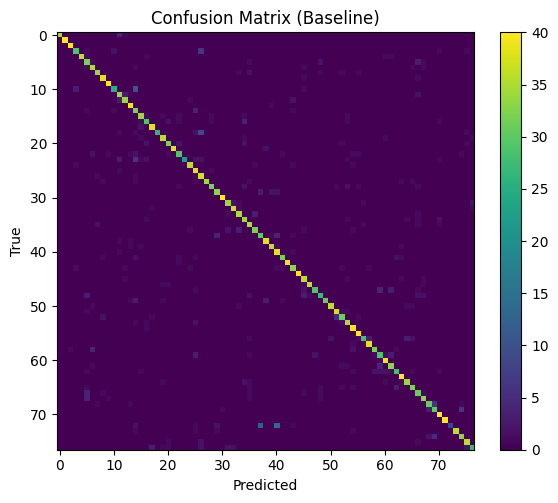

In [41]:

# Evaluación final en test (baseline vs BERT si está)
try:
    # BERT eval
    bert_logits = []
    import torch
    for b in range(0, len(tokenized["test"]), 64):
        batch = tokenized["test"][b:b+64]
        enc = tokenizer(batch["text"], return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            out = model(**enc).logits
        bert_logits.append(out.cpu().numpy())
    import numpy as np
    bert_logits = np.vstack(bert_logits)
    bert_preds = bert_logits.argmax(axis=1)
    bert_acc = accuracy_score(dataset["test"]["label"], bert_preds)
    bert_f1 = f1_score(dataset["test"]["label"], bert_preds, average="macro")
    print(f"BERT Test Accuracy: {bert_acc:.4f}  Macro-F1: {bert_f1:.4f}")
except Exception as e:
    print("BERT evaluación omitida:", e)

# Baseline eval (ya calculado). Reporte de clasificación sobre test:
print("\nBaseline (TF‑IDF + LR) - Classification report (test):")
print(classification_report(test_labels, test_pred, target_names=label_list, digits=4))

# Gráfico: matriz de confusión (baseline)
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Baseline)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()


In [1]:
import os, re, time, uuid, base64, io, json
from datetime import datetime
from typing import List, Optional, Dict, Any

# --- Privacidad / PII ---
EMAIL_RE = re.compile(r'([A-Za-z0-9._%+-]+)@([A-Za-z0-9.-]+\.[A-Za-z]{2,})')
DIGITS_RE = re.compile(r'\b(\d{6,})\b')

def mask_email(text:str) -> str:
    def repl(m):
        local, domain = m.group(1), m.group(2)
        masked_local = local[0] + "***" + local[-1] if len(local) > 2 else "***"
        return f"{masked_local}@{domain}"
    return EMAIL_RE.sub(repl, text)

def mask_numbers(text:str) -> str:
    # Enmascara secuencias largas (p.ej., cuentas, tarjetas)
    return DIGITS_RE.sub(lambda m: "*"*(len(m.group(1))-4) + m.group(1)[-4:], text)

def sanitize_text(text:str) -> str:
    return mask_numbers(mask_email(text or ""))

# --- Auditoría simple en memoria ---
AUDIT_LOG: List[Dict[str,Any]] = []
def log_event(event_type:str, payload:Dict[str,Any]):
    safe = json.loads(json.dumps(payload, default=str))  # copia segura
    if 'text' in safe: safe['text'] = sanitize_text(safe['text'])
    if 'ocr_text' in safe: safe['ocr_text'] = sanitize_text(safe['ocr_text'])
    if 'dest_account' in safe: safe['dest_account'] = sanitize_text(str(safe['dest_account']))
    AUDIT_LOG.append({
        "ts": datetime.utcnow().isoformat(),
        "event_id": str(uuid.uuid4()),
        "type": event_type,
        "payload": safe
    })

# --- Feedback del cliente ---
FEEDBACK: List[Dict[str,Any]] = []
def record_feedback(score:int, helpful:bool, meta:Optional[Dict[str,Any]]=None):
    FEEDBACK.append({"score": int(score), "helpful": bool(helpful), "meta": meta or {}, "ts": datetime.utcnow().isoformat()})

def feedback_stats():
    if not FEEDBACK:
        return {"count":0, "avg_score": None, "helpful_rate": None}
    count = len(FEEDBACK)
    avg = sum(f["score"] for f in FEEDBACK) / count
    helpful_rate = sum(1 for f in FEEDBACK if f["helpful"]) / count
    return {"count":count, "avg_score": round(avg,2), "helpful_rate": round(helpful_rate,3)}


# App mínima (FastAPI) + NLU/NER fallback + endpoints

In [42]:
# === Celda 1: App mínima + NLU/NER + endpoints (sin ngrok) ===
import re, json
from datetime import datetime
from fastapi import FastAPI
from pydantic import BaseModel

# --- NLU fallback: intents por keywords ---
KNOWN_INTENTS = {
    "check_balance": ["saldo", "balance", "cuánto tengo", "consulta saldo"],
    "transfer": ["transferir", "transferencia", "enviar dinero", "pase"],
    "card_arrival": ["tarjeta", "envío tarjeta", "mi tarjeta no llega"],
    "lost_card": ["perdí tarjeta", "bloquear tarjeta", "robo tarjeta"],
    "charge_dispute": ["reclamo", "desconozco consumo", "disputa de cargo"],
    "complaint": ["queja", "reclamo formal", "mala atención"],
}

def _keyword_intent(text:str):
    txt = (text or "").lower()
    best_intent, best_score = "fallback", 0.35
    for intent, kws in KNOWN_INTENTS.items():
        score = sum(1 for k in kws if k in txt) / max(1,len(kws))
        if score > best_score:
            best_intent, best_score = intent, score
    return best_intent, min(0.95, 0.5 + best_score)

def predict_intent(text:str):
    # Si ya tenías un pipeline real en globals() (banking_intent_pipeline), úsalo:
    try:
        pipe = globals().get("banking_intent_pipeline", None)
        if pipe:
            out = pipe(text)  # [{'label':'transfer', 'score':0.87}]
            return out[0]["label"], float(out[0]["score"])
    except Exception:
        pass
    # Fallback
    return _keyword_intent(text)

# --- NER fallback con regex ---
AMOUNT_RE  = re.compile(r'(\$?\s?\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?)', re.I)
ACCOUNT_RE = re.compile(r'\b(\d{10,20})\b')
DATE_RE    = re.compile(r'\b(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})\b')

def extract_entities(text:str):
    ents = []
    nlp = globals().get("ner_nlp", None)  # usa spaCy si ya lo cargaste antes
    if nlp:
        try:
            doc = nlp(text or "")
            ents += [{"text": e.text, "label": e.label_} for e in doc.ents]
        except Exception:
            pass
    for m in AMOUNT_RE.findall(text or ""):  ents.append({"text": m.strip(), "label": "AMOUNT"})
    for m in ACCOUNT_RE.findall(text or ""): ents.append({"text": m, "label": "ACCOUNT"})
    for m in DATE_RE.findall(text or ""):    ents.append({"text": m, "label": "DATE"})
    return ents

# --- FastAPI app mínima ---
app = FastAPI(title="API demo mínima", version="1.0.0")

class TextIn(BaseModel):
    text: str

@app.get("/health")
def health():
    return {"status":"ok", "time": datetime.utcnow().isoformat()}

@app.post("/predict_intent")
def api_predict_intent(payload: TextIn):
    intent, score = predict_intent(payload.text)
    return {"intent": intent, "confidence": round(score,3)}

@app.post("/extract_entities")
def api_extract_entities(payload: TextIn):
    return {"entities": extract_entities(payload.text)}


# Arrancar servidor (puerto libre) y esperar /health

In [43]:
# === Celda 2: Arranque fiable (puerto libre + hilo) y espera /health ===
import threading, socket, time, requests, uvicorn

def find_free_port():
    s = socket.socket()
    s.bind(('', 0))
    port = s.getsockname()[1]
    s.close()
    return port

PORT = find_free_port()

config = uvicorn.Config(app, host="0.0.0.0", port=PORT, log_level="info")
server = uvicorn.Server(config)
server.install_signal_handlers = lambda: None  # necesario en hilo

t = threading.Thread(target=server.run, daemon=True)
t.start()

BASE_URL = f"http://127.0.0.1:{PORT}"
print("➡️ Levantando API en", BASE_URL)

last_err = None
for _ in range(90):  # ~45s
    try:
        r = requests.get(f"{BASE_URL}/health", timeout=1.5)
        if r.status_code == 200:
            print("✅ API lista en", BASE_URL)
            print("health:", r.json())
            break
        last_err = f"status={r.status_code} body={r.text[:120]}"
    except Exception as e:
        last_err = repr(e)
    time.sleep(0.5)
else:
    raise RuntimeError(f"❌ No respondió /health en {BASE_URL}. Último: {last_err}")


INFO:     Started server process [412]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:36403 (Press CTRL+C to quit)


➡️ Levantando API en http://127.0.0.1:36403
INFO:     127.0.0.1:46470 - "GET /health HTTP/1.1" 200 OK
✅ API lista en http://127.0.0.1:36403
health: {'status': 'ok', 'time': '2025-08-18T04:46:11.825907'}


# Prueba rápida NLU/NER

In [44]:
# === Celda 3: Test rápido de NLU/NER ===
def jprint(label, resp):
    from pprint import pprint
    print("\n▶", label)
    try:
        pprint(resp.json())
    except Exception:
        print(resp)

texto = "Quiero transferir $25.50 a la cuenta 0011223344556677 mañana"

r_int  = requests.post(f"{BASE_URL}/predict_intent", json={"text": texto}, timeout=10)
jprint("predict_intent", r_int)

r_ents = requests.post(f"{BASE_URL}/extract_entities", json={"text": texto}, timeout=10)
jprint("extract_entities", r_ents)

assert r_int.status_code == 200 and r_ents.status_code == 200, "❌ NLU/NER"
print("✅ Prueba NLU/NER OK")


INFO:     127.0.0.1:33074 - "POST /predict_intent HTTP/1.1" 200 OK

▶ predict_intent
{'confidence': 0.85, 'intent': 'fallback'}
INFO:     127.0.0.1:33076 - "POST /extract_entities HTTP/1.1" 200 OK

▶ extract_entities
{'entities': [{'label': 'AMOUNT', 'text': '$25.50'},
              {'label': 'AMOUNT', 'text': '001'},
              {'label': 'AMOUNT', 'text': '122'},
              {'label': 'AMOUNT', 'text': '334'},
              {'label': 'AMOUNT', 'text': '455'},
              {'label': 'AMOUNT', 'text': '667'},
              {'label': 'AMOUNT', 'text': '7'},
              {'label': 'ACCOUNT', 'text': '0011223344556677'}]}
✅ Prueba NLU/NER OK


In [45]:
# %pip install pillow pytesseract networkx


# Privacidad (PII) + Auditoría

In [46]:
import re, uuid, json
from datetime import datetime
from typing import List, Dict, Any, Optional

EMAIL_RE = re.compile(r'([A-Za-z0-9._%+-]+)@([A-Za-z0-9.-]+\.[A-Za-z]{2,})')
DIGITS_RE = re.compile(r'\b(\d{6,})\b')

def mask_email(text:str) -> str:
    def repl(m):
        local, domain = m.group(1), m.group(2)
        masked_local = local[0] + "***" + local[-1] if len(local) > 2 else "***"
        return f"{masked_local}@{domain}"
    return EMAIL_RE.sub(repl, text or "")

def mask_numbers(text:str) -> str:
    return DIGITS_RE.sub(lambda m: "*"*(len(m.group(1))-4) + m.group(1)[-4:], text or "")

def sanitize_text(text:str) -> str:
    return mask_numbers(mask_email(text or ""))

AUDIT_LOG: List[Dict[str,Any]] = []

def log_event(event_type:str, payload:Dict[str,Any]):
    safe = json.loads(json.dumps(payload, default=str))
    for k in ("text","ocr_text","dest_account"):
        if k in safe:
            safe[k] = sanitize_text(str(safe[k]))
    AUDIT_LOG.append({
        "ts": datetime.utcnow().isoformat(),
        "event_id": str(uuid.uuid4())[:8],
        "type": event_type,
        "payload": safe
    })

FEEDBACK: List[Dict[str,Any]] = []

def record_feedback(score:int, helpful:bool, meta:Optional[Dict[str,Any]]=None):
    FEEDBACK.append({"score": int(score), "helpful": bool(helpful), "meta": meta or {}, "ts": datetime.utcnow().isoformat()})

def feedback_stats():
    if not FEEDBACK:
        return {"count":0, "avg_score": None, "helpful_rate": None}
    count = len(FEEDBACK)
    avg = sum(f["score"] for f in FEEDBACK)/count
    helpful_rate = sum(1 for f in FEEDBACK if f["helpful"])/count
    return {"count":count, "avg_score": round(avg,2), "helpful_rate": round(helpful_rate,3)}


# OCR + Clasificación de documentos (heurísticas)

In [47]:
import io
from PIL import Image
try:
    import pytesseract
except Exception:
    pytesseract = None  # si faltara, /ocr devolverá error claro

def ocr_image_from_bytes(image_bytes: bytes, lang="spa"):
    if pytesseract is None:
        raise RuntimeError("pytesseract no está instalado. Ejecuta: %pip install pytesseract pillow")
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    return pytesseract.image_to_string(img, lang=lang)

def classify_document_rule(text:str) -> str:
    t = (text or "").lower()
    if any(k in t for k in ["cheque", "no. cheque", "librado", "banco"]):
        return "cheque"
    if any(k in t for k in ["cédula", "cedula", "identificación", "identificacion", "dni", "ci"]):
        return "identificacion"
    if any(k in t for k in ["depósito", "deposito", "voucher", "comprobante", "referencia"]):
        return "voucher/desposito"
    return "otro"

def classify_document(image_bytes: bytes, lang="spa") -> Dict[str,Any]:
    text = ocr_image_from_bytes(image_bytes, lang=lang)
    return {"label": classify_document_rule(text), "ocr_text": text}


# Mini Knowledge Graph (networkx)

In [48]:
import networkx as nx

KG = nx.DiGraph()

def build_kg():
    KG.clear()
    # Productos
    KG.add_node(("producto","cuenta_corriente"))
    KG.add_node(("producto","tarjeta_credito"))
    KG.add_node(("producto","cuenta_ahorros"))
    # Políticas
    KG.add_node(("pol","comision_mant"))
    KG.add_node(("pol","limite_transfer"))
    KG.add_node(("pol","requisito_doc"))
    KG.add_node(("pol","tiempo_envio_tarjeta"))
    # Relaciones (ejemplo demo)
    KG.add_edge(("producto","cuenta_corriente"), ("pol","comision_mant"), info={"valor":"$5/mes"})
    KG.add_edge(("producto","cuenta_corriente"), ("pol","limite_transfer"), info={"valor":"$5,000/día"})
    KG.add_edge(("producto","tarjeta_credito"), ("pol","requisito_doc"), info={"valor":"cédula + comprobante ingresos"})
    KG.add_edge(("producto","tarjeta_credito"), ("pol","tiempo_envio_tarjeta"), info={"valor":"3-5 días hábiles"})
    KG.add_edge(("producto","cuenta_ahorros"), ("pol","limite_transfer"), info={"valor":"$2,000/día"})

build_kg()

def query_kg(intent:str, entities:List[Dict[str,Any]]) -> Dict[str,str]:
    out = {}
    if intent in ("check_balance","transfer"):
        edge = KG.get_edge_data(("producto","cuenta_corriente"), ("pol","limite_transfer"))
        if edge: out["limite_transfer"] = edge["info"]["valor"]
    if intent in ("card_arrival","card_status","card_arrival_status"):
        edge = KG.get_edge_data(("producto","tarjeta_credito"), ("pol","tiempo_envio_tarjeta"))
        if edge: out["tiempo_envio_tarjeta"] = edge["info"]["valor"]
    return out


# Gestor de diálogo con memoria + Escalamiento

In [49]:
from collections import deque

DIALOG_MEMORY = deque(maxlen=10)
ESCALATION_INTENTS = {"complaint", "lost_card_unresolved", "charge_dispute", "fraud_report"}
CONFIDENCE_THRESHOLD = 0.70

def dialog_reply(user_text:str, ocr_text:str="") -> Dict[str,Any]:
    # Usa predict_intent / extract_entities de tu Celda 1
    intent, conf = predict_intent(user_text)
    ents = extract_entities(f"{user_text or ''} {ocr_text or ''}")
    kg_info = query_kg(intent, ents)

    needs_escalation = (conf < CONFIDENCE_THRESHOLD) or (intent in ESCALATION_INTENTS)

    reply = None  # aquí puedes enchufar tu modelo de diálogo si lo tienes en globals()['dialog_model']
    if not reply:
        if intent == "check_balance":
            reply = "Puedo ayudarte a consultar tu saldo. ¿Te identificas primero? (por seguridad)"
        elif intent == "transfer":
            reply = "Entendido. Para transferir necesito el monto y la cuenta destino. ¿Me confirmas esos datos?"
        elif intent == "card_arrival":
            eta = kg_info.get("tiempo_envio_tarjeta", "3-5 días hábiles")
            reply = f"He verificado que el envío típico de tarjeta toma {eta}. ¿Deseas rastrear tu envío?"
        else:
            reply = "Te entiendo. ¿Puedes darme un poco más de detalle para ayudarte mejor?"

    if needs_escalation:
        reply += "\n\n🔄 Te comunico con un agente humano para resolverlo con prioridad."

    DIALOG_MEMORY.append({"user": sanitize_text(user_text), "intent": intent, "conf": round(conf,3), "ents": ents})
    log_event("chat", {"text": user_text, "intent": intent, "confidence": conf, "ents": ents, "kg": kg_info, "escalation": needs_escalation})
    return {"reply": reply, "intent": intent, "confidence": round(conf,3), "entities": ents, "kg_info": kg_info, "escalation": needs_escalation}


# Transacciones mock (balance / transfer)

In [50]:
from decimal import Decimal, InvalidOperation

USER_BALANCES = {"demo_user": Decimal("1234.56")}
DAILY_TRANSFER_LIMIT = Decimal("5000.00")

def get_balance(user_id:str="demo_user") -> Dict[str,Any]:
    bal = USER_BALANCES.get(user_id, Decimal("0.00"))
    return {"user_id": user_id, "balance": f"{bal:.2f}", "currency":"USD"}

def validate_amount(amt:str) -> Decimal:
    amt = (amt or "").replace("$","").replace(",","").strip()
    try:
        val = Decimal(amt)
        if val <= 0: raise InvalidOperation
        return val
    except Exception:
        raise ValueError("Monto inválido")

def transfer_funds(dest_account:str, amount_str:str, user_id:str="demo_user", currency:str="USD") -> Dict[str,Any]:
    amount = validate_amount(amount_str)
    if amount > DAILY_TRANSFER_LIMIT:
        raise ValueError(f"Excede el límite diario de {DAILY_TRANSFER_LIMIT}")
    bal = USER_BALANCES.get(user_id, Decimal("0.00"))
    if amount > bal:
        raise ValueError("Fondos insuficientes")
    USER_BALANCES[user_id] = bal - amount
    tx_id = str(uuid.uuid4())[:8]
    log_event("transfer", {"user_id":user_id, "dest_account":dest_account, "amount": str(amount), "currency":currency, "tx_id": tx_id})
    return {"status":"success", "tx_id": tx_id, "dest_account": sanitize_text(dest_account), "amount": f"{amount:.2f}", "currency":currency, "new_balance": f"{USER_BALANCES[user_id]:.2f}"}


# Extiende la API existente con las nuevas rutas

In [51]:
from fastapi import UploadFile, File, Form
from pydantic import BaseModel

# Modelos de entrada
class TransferIn(BaseModel):
    dest_account: str
    amount: str
    currency: Optional[str] = "USD"
    user_id: Optional[str] = "demo_user"

class FeedbackIn(BaseModel):
    score: int
    helpful: bool
    meta: Optional[Dict[str,Any]] = None

@app.post("/ocr")
async def api_ocr(file: UploadFile = File(...), lang: str = Form("spa")):
    content = await file.read()
    try:
        text = ocr_image_from_bytes(content, lang=lang)
        log_event("ocr", {"len_bytes": len(content), "ocr_text": text[:200]})
        return {"ocr_text": text}
    except Exception as e:
        log_event("ocr_error", {"error": str(e)})
        return {"error": str(e)}

@app.post("/classify_document")
async def api_classify_document(file: UploadFile = File(...), lang: str = Form("spa")):
    content = await file.read()
    try:
        result = classify_document(content, lang=lang)
        log_event("doc_class", {"len_bytes": len(content), "label": result["label"]})
        return result
    except Exception as e:
        log_event("doc_class_error", {"error": str(e)})
        return {"error": str(e)}

@app.post("/chat")
def api_chat(payload: TextIn):
    out = dialog_reply(payload.text)
    return out

@app.get("/balance")
def api_balance(user_id:str="demo_user"):
    out = get_balance(user_id=user_id)
    log_event("balance", {"user_id": user_id})
    return out

@app.post("/transfer")
def api_transfer(payload: TransferIn):
    try:
        out = transfer_funds(dest_account=payload.dest_account, amount_str=payload.amount, user_id=payload.user_id, currency=payload.currency)
        return out
    except Exception as e:
        log_event("transfer_error", {"error": str(e), "payload": payload.dict()})
        return {"status":"error", "message": str(e)}

@app.post("/feedback")
def api_feedback(payload: FeedbackIn):
    record_feedback(score=payload.score, helpful=payload.helpful, meta=payload.meta)
    return {"status":"ok"}

@app.get("/feedback_stats")
def api_feedback_stats():
    return feedback_stats()

@app.get("/audit_log")
def api_audit():
    return {"count": len(AUDIT_LOG), "items": AUDIT_LOG[-50:]}


# Pruebas rápidas (todo en acción)

In [52]:
import requests, io
from PIL import Image, ImageDraw

def jprint(name, resp):
    from pprint import pprint
    print("\n▶", name)
    try: pprint(resp.json())
    except Exception: print(resp)

# 1) NLU/NER
texto = "Necesito transferir $50 a la cuenta 0011223344556677 mañana"
r_int  = requests.post(f"{BASE_URL}/predict_intent", json={"text": texto}, timeout=10); jprint("predict_intent", r_int)
r_ents = requests.post(f"{BASE_URL}/extract_entities", json={"text": texto}, timeout=10); jprint("extract_entities", r_ents)

# 2) Chat + escalamiento
jprint("chat (transfer)", requests.post(f"{BASE_URL}/chat", json={"text":"Quiero transferir 20 dólares a 998877665544"}, timeout=10))
jprint("chat (reclamo)", requests.post(f"{BASE_URL}/chat", json={"text":"Quiero poner un reclamo por un cargo que no reconozco"}, timeout=10))

# 3) Balance y Transfer
jprint("balance antes", requests.get(f"{BASE_URL}/balance", params={"user_id":"demo_user"}, timeout=10))
jprint("transfer ok", requests.post(f"{BASE_URL}/transfer", json={"dest_account":"0011223344556677","amount":"20.00"}, timeout=10))
jprint("balance después", requests.get(f"{BASE_URL}/balance", params={"user_id":"demo_user"}, timeout=10))

# 4) OCR y Clasificación (imagen sintetizada)
buf = io.BytesIO()
img = Image.new("RGB", (800, 300), (255,255,255))
d = ImageDraw.Draw(img); d.text((20,20), "Comprobante de depósito\nReferencia: 998877\nCuenta destino: 001122334455", fill=(0,0,0))
img.save(buf, format="PNG"); buf.seek(0)
files = {'file': ('voucher.png', buf, 'image/png')}
jprint("classify_document", requests.post(f"{BASE_URL}/classify_document", files=files, data={"lang":"spa"}, timeout=30))

# 5) Feedback + Auditoría
requests.post(f"{BASE_URL}/feedback", json={"score":5,"helpful":True,"meta":{"flow":"transfer"}}, timeout=10)
requests.post(f"{BASE_URL}/feedback", json={"score":3,"helpful":False,"meta":{"flow":"reclamo"}}, timeout=10)
jprint("feedback_stats", requests.get(f"{BASE_URL}/feedback_stats", timeout=10))
jprint("audit_log", requests.get(f"{BASE_URL}/audit_log", timeout=10))


INFO:     127.0.0.1:41444 - "POST /predict_intent HTTP/1.1" 200 OK

▶ predict_intent
{'confidence': 0.85, 'intent': 'fallback'}
INFO:     127.0.0.1:41448 - "POST /extract_entities HTTP/1.1" 200 OK

▶ extract_entities
{'entities': [{'label': 'AMOUNT', 'text': '$50'},
              {'label': 'AMOUNT', 'text': '001'},
              {'label': 'AMOUNT', 'text': '122'},
              {'label': 'AMOUNT', 'text': '334'},
              {'label': 'AMOUNT', 'text': '455'},
              {'label': 'AMOUNT', 'text': '667'},
              {'label': 'AMOUNT', 'text': '7'},
              {'label': 'ACCOUNT', 'text': '0011223344556677'}]}
INFO:     127.0.0.1:41456 - "POST /chat HTTP/1.1" 200 OK

▶ chat (transfer)
{'confidence': 0.85,
 'entities': [{'label': 'AMOUNT', 'text': '20'},
              {'label': 'AMOUNT', 'text': '998'},
              {'label': 'AMOUNT', 'text': '877'},
              {'label': 'AMOUNT', 'text': '665'},
              {'label': 'AMOUNT', 'text': '544'},
              {'label': 

# Prueba Visual

In [53]:
# === Celda 11: UI Gradio (Chat, Transacciones, Documentos, Métricas, Auditoría) ===
# Si no tienes gradio instalado, descomenta esta línea:
# %pip install gradio

import json
import gradio as gr

# ---------- Helpers de presentación ----------
def pretty_json(obj):
    try:
        return json.dumps(obj, ensure_ascii=False, indent=2)
    except Exception:
        return str(obj)

# ---------- Callbacks de cada pestaña ----------

# Chat: usa dialog_reply(...) ya definido
def cb_chat(user_msg, chat_history):
    try:
        out = dialog_reply(user_msg)
        reply = out.get("reply", "(sin respuesta)")
        # Adjunta metadatos legibles
        meta = {
            "intent": out.get("intent"),
            "confidence": out.get("confidence"),
            "escalation": out.get("escalation"),
            "entities": out.get("entities"),
            "kg_info": out.get("kg_info"),
        }
        chat_history = chat_history + [[user_msg, reply]]
        return chat_history, pretty_json(meta)
    except Exception as e:
        chat_history = chat_history + [[user_msg, f"⚠️ Error: {e}"]]
        return chat_history, pretty_json({"error": str(e)})

# Transacciones
def cb_balance(user_id):
    try:
        res = get_balance(user_id=user_id or "demo_user")
        return pretty_json(res)
    except Exception as e:
        return pretty_json({"error": str(e)})

def cb_transfer(user_id, dest_account, amount, currency):
    try:
        res = transfer_funds(dest_account=dest_account, amount_str=amount, user_id=user_id or "demo_user", currency=currency or "USD")
        return pretty_json(res)
    except Exception as e:
        return pretty_json({"status":"error","message":str(e)})

# Documentos (OCR / Clasificación)
def cb_ocr(image, lang):
    if image is None:
        return pretty_json({"error":"Sube una imagen"})
    try:
        # gradio da PIL Image; conviértela a bytes
        import io
        buf = io.BytesIO()
        image.save(buf, format="PNG")
        text = ocr_image_from_bytes(buf.getvalue(), lang=lang)
        log_event("ocr_ui", {"len_bytes": len(buf.getvalue()), "lang": lang})
        return pretty_json({"ocr_text": text})
    except Exception as e:
        return pretty_json({"error": str(e)})

def cb_classify(image, lang):
    if image is None:
        return pretty_json({"error":"Sube una imagen"})
    try:
        import io
        buf = io.BytesIO()
        image.save(buf, format="PNG")
        res = classify_document(buf.getvalue(), lang=lang)
        log_event("doc_class_ui", {"len_bytes": len(buf.getvalue()), "lang": lang, "label": res.get("label")})
        return pretty_json(res)
    except Exception as e:
        return pretty_json({"error": str(e)})

# Métricas (feedback)
def cb_feedback(score, helpful, flow):
    try:
        record_feedback(int(score), bool(helpful), {"flow": flow or "general"})
        return pretty_json({"status":"ok"})
    except Exception as e:
        return pretty_json({"error": str(e)})

def cb_feedback_stats():
    try:
        return pretty_json(feedback_stats())
    except Exception as e:
        return pretty_json({"error": str(e)})

# Auditoría
def cb_audit():
    try:
        # muestra últimos 30 eventos
        items = AUDIT_LOG[-30:]
        return pretty_json({"count": len(AUDIT_LOG), "last_items": items})
    except Exception as e:
        return pretty_json({"error": str(e)})

# ---------- Construcción de la UI ----------
with gr.Blocks(title="Banco Digital - Chatbot Multimodal", css="""
#meta-panel { max-height: 300px; overflow:auto; }
""") as demo:
    gr.Markdown("## 🏦 Chatbot Multimodal — Banco Digital")
    gr.Markdown("Prueba el chat, sube documentos para OCR/clasificación, realiza transacciones mock y registra feedback.")

    with gr.Tab("💬 Chat"):
        with gr.Row():
            chatbot = gr.Chatbot(label="Asistente", height=350)
            meta = gr.Code(label="Metadatos (intent, entidades, escalamiento)", language="json", elem_id="meta-panel")
        with gr.Row():
            user_msg = gr.Textbox(label="Escribe tu mensaje", placeholder="Ej: Necesito transferir 50 dólares a la cuenta 998877665544", scale=4)
            send_btn = gr.Button("Enviar", variant="primary", scale=1)
        # estado del historial
        state_hist = gr.State([])

        send_btn.click(cb_chat, inputs=[user_msg, state_hist], outputs=[chatbot, meta]).then(
            lambda: "", None, user_msg
        )

    with gr.Tab("💸 Transacciones"):
        with gr.Row():
            user_id = gr.Textbox(label="User ID", value="demo_user")
            currency = gr.Textbox(label="Moneda", value="USD")
        with gr.Row():
            bal_btn = gr.Button("Consultar saldo")
            bal_out = gr.Code(label="Saldo", language="json")
        bal_btn.click(cb_balance, inputs=[user_id], outputs=[bal_out])

        gr.Markdown("---")
        gr.Markdown("### Transferencia")
        with gr.Row():
            dest_account = gr.Textbox(label="Cuenta destino", placeholder="0011223344556677")
            amount = gr.Textbox(label="Monto", placeholder="25.50")
        tx_btn = gr.Button("Transferir")
        tx_out = gr.Code(label="Resultado transferencia", language="json")
        tx_btn.click(cb_transfer, inputs=[user_id, dest_account, amount, currency], outputs=[tx_out])

    with gr.Tab("🧾 Documentos"):
        with gr.Row():
            img_in = gr.Image(type="pil", label="Imagen (voucher/cheque/ID)")
            lang = gr.Dropdown(choices=["spa","eng"], value="spa", label="Idioma OCR")
        with gr.Row():
            ocr_btn = gr.Button("Ejecutar OCR")
            cls_btn = gr.Button("Clasificar Documento")
        with gr.Row():
            ocr_out = gr.Code(label="Resultado OCR", language="json")
            cls_out = gr.Code(label="Resultado Clasificación", language="json")
        ocr_btn.click(cb_ocr, inputs=[img_in, lang], outputs=[ocr_out])
        cls_btn.click(cb_classify, inputs=[img_in, lang], outputs=[cls_out])

    with gr.Tab("📊 Métricas"):
        with gr.Row():
            score = gr.Slider(1, 5, step=1, value=5, label="Satisfacción (1–5)")
            helpful = gr.Checkbox(True, label="¿Fue útil?")
            flow = gr.Textbox(label="Flujo", placeholder="transfer / reclamo / general", value="transfer")
        fb_btn = gr.Button("Enviar feedback", variant="primary")
        fb_out = gr.Code(label="Resultado feedback", language="json")
        fb_btn.click(cb_feedback, inputs=[score, helpful, flow], outputs=[fb_out])

        gr.Markdown("### Estadísticas")
        stats_btn = gr.Button("Actualizar estadísticas")
        stats_out = gr.Code(label="Estadísticas", language="json")
        stats_btn.click(cb_feedback_stats, inputs=None, outputs=[stats_out])

    with gr.Tab("🧪 Auditoría"):
        audit_btn = gr.Button("Ver últimos eventos")
        audit_out = gr.Code(label="Audit log", language="json")
        audit_btn.click(cb_audit, inputs=None, outputs=[audit_out])

    gr.Markdown("---")
    gr.Markdown("**Tip**: esta UI llama directamente a tus funciones internas del notebook (no a la API HTTP), por lo que funciona incluso si no expones puertos.")

# Lanza Gradio (en Colab verás un link público de manera automática)
demo.launch(share=False)


/tmp/ipython-input-3217353801.py:111: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Asistente", height=350)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# API FastAPI por HTTP

In [54]:
# === Celda 12: UI Gradio (usa la API FastAPI por HTTP con BASE_URL) ===
# Si no tienes gradio instalado:
# %pip install gradio

import io, json, requests
import gradio as gr
from PIL import Image

# Usa el BASE_URL que dejó tu celda de arranque; si no existe, fallback a localhost:8000
try:
    BASE_URL
except NameError:
    BASE_URL = "http://127.0.0.1:8000"

def pretty_json(obj):
    try:
        return json.dumps(obj, ensure_ascii=False, indent=2)
    except Exception:
        return str(obj)

def _full_url(base_url, path):
    base = (base_url or BASE_URL).rstrip("/")
    return f"{base}{path}"

def _req_get(base_url, path, params=None, timeout=15):
    url = _full_url(base_url, path)
    try:
        r = requests.get(url, params=params or {}, timeout=timeout)
        data = r.json() if r.headers.get("content-type","").startswith("application/json") else r.text
        return r.status_code, data
    except Exception as e:
        return 0, {"error": str(e), "url": url}

def _req_post_json(base_url, path, payload=None, timeout=30):
    url = _full_url(base_url, path)
    try:
        r = requests.post(url, json=payload or {}, timeout=timeout)
        data = r.json() if r.headers.get("content-type","").startswith("application/json") else r.text
        return r.status_code, data
    except Exception as e:
        return 0, {"error": str(e), "url": url}

def _req_post_file(base_url, path, file_tuple, data=None, timeout=60):
    url = _full_url(base_url, path)
    try:
        r = requests.post(url, files={"file": file_tuple}, data=data or {}, timeout=timeout)
        data = r.json() if r.headers.get("content-type","").startswith("application/json") else r.text
        return r.status_code, data
    except Exception as e:
        return 0, {"error": str(e), "url": url}

# ---------- Callbacks (HTTP) ----------

def cb_chat(base_url, user_msg, chat_history):
    if not user_msg:
        return chat_history, pretty_json({"error": "Mensaje vacío"})
    status, data = _req_post_json(base_url, "/chat", {"text": user_msg})
    if status == 200 and isinstance(data, dict):
        reply = data.get("reply", "(sin respuesta)")
        meta = {
            "intent": data.get("intent"),
            "confidence": data.get("confidence"),
            "escalation": data.get("escalation"),
            "entities": data.get("entities"),
            "kg_info": data.get("kg_info"),
            "status": status
        }
        chat_history = (chat_history or []) + [[user_msg, reply]]
        return chat_history, pretty_json(meta)
    else:
        chat_history = (chat_history or []) + [[user_msg, f"⚠️ Error ({status}): {data}"]]
        return chat_history, pretty_json({"status": status, "data": data})

def cb_balance(base_url, user_id):
    status, data = _req_get(base_url, "/balance", params={"user_id": user_id or "demo_user"})
    return pretty_json({"status": status, "data": data})

def cb_transfer(base_url, user_id, dest_account, amount, currency):
    payload = {
        "dest_account": dest_account or "",
        "amount": amount or "",
        "currency": (currency or "USD"),
        "user_id": user_id or "demo_user",
    }
    status, data = _req_post_json(base_url, "/transfer", payload)
    return pretty_json({"status": status, "data": data})

def _pil_to_png_bytes(img: Image.Image):
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    return buf.getvalue()

def cb_ocr(base_url, img, lang):
    if img is None:
        return pretty_json({"error": "Sube una imagen"})
    png = _pil_to_png_bytes(img)
    status, data = _req_post_file(base_url, "/ocr", ("upload.png", png, "image/png"), data={"lang": lang or "spa"})
    return pretty_json({"status": status, "data": data})

def cb_classify(base_url, img, lang):
    if img is None:
        return pretty_json({"error": "Sube una imagen"})
    png = _pil_to_png_bytes(img)
    status, data = _req_post_file(base_url, "/classify_document", ("upload.png", png, "image/png"), data={"lang": lang or "spa"})
    return pretty_json({"status": status, "data": data})

def cb_feedback(base_url, score, helpful, flow):
    payload = {"score": int(score or 5), "helpful": bool(helpful), "meta": {"flow": flow or "general"}}
    status, data = _req_post_json(base_url, "/feedback", payload)
    return pretty_json({"status": status, "data": data})

def cb_feedback_stats(base_url):
    status, data = _req_get(base_url, "/feedback_stats")
    return pretty_json({"status": status, "data": data})

def cb_audit(base_url):
    status, data = _req_get(base_url, "/audit_log")
    # mostrar solo últimos N items si es muy grande
    if isinstance(data, dict) and "items" in data and isinstance(data["items"], list) and len(data["items"]) > 50:
        data = {**data, "items": data["items"][-50:]}
    return pretty_json({"status": status, "data": data})

# ---------- Construcción de la UI ----------
with gr.Blocks(title="Banco Digital - Chatbot (HTTP API)") as demo_http:
    gr.Markdown("## 🏦 Chatbot Multimodal — Cliente HTTP")
    gr.Markdown("Esta UI llama a tu **API FastAPI** usando `BASE_URL`.")

    with gr.Row():
        base_url_tb = gr.Textbox(label="BASE_URL", value=BASE_URL, interactive=True, scale=3)
        ping_btn = gr.Button("Probar /health", scale=1)
        ping_out = gr.Code(label="Resultado /health", language="json")

    def ping(base_url):
        status, data = _req_get(base_url, "/health", params=None, timeout=5)
        return pretty_json({"status": status, "data": data})
    ping_btn.click(ping, inputs=[base_url_tb], outputs=[ping_out])

    with gr.Tab("💬 Chat"):
        with gr.Row():
            chatbot = gr.Chatbot(label="Asistente", height=350)
            meta = gr.Code(label="Metadatos", language="json")
        with gr.Row():
            user_msg = gr.Textbox(label="Mensaje", placeholder="Ej: Necesito transferir 50 dólares a la cuenta 998877665544", scale=4)
            send_btn = gr.Button("Enviar", variant="primary", scale=1)
        hist = gr.State([])

        send_btn.click(cb_chat, inputs=[base_url_tb, user_msg, hist], outputs=[chatbot, meta]).then(
            lambda: "", None, user_msg
        )

    with gr.Tab("💸 Transacciones"):
        with gr.Row():
            user_id = gr.Textbox(label="User ID", value="demo_user")
            currency = gr.Textbox(label="Moneda", value="USD")
        with gr.Row():
            bal_btn = gr.Button("Consultar saldo")
            bal_out = gr.Code(label="Saldo", language="json")
        bal_btn.click(cb_balance, inputs=[base_url_tb, user_id], outputs=[bal_out])

        gr.Markdown("---")
        gr.Markdown("### Transferencia")
        with gr.Row():
            dest_account = gr.Textbox(label="Cuenta destino", placeholder="0011223344556677")
            amount = gr.Textbox(label="Monto", placeholder="25.50")
        tx_btn = gr.Button("Transferir")
        tx_out = gr.Code(label="Resultado", language="json")
        tx_btn.click(cb_transfer, inputs=[base_url_tb, user_id, dest_account, amount, currency], outputs=[tx_out])

    with gr.Tab("🧾 Documentos"):
        with gr.Row():
            img_in = gr.Image(type="pil", label="Imagen (voucher/cheque/ID)")
            lang = gr.Dropdown(choices=["spa","eng"], value="spa", label="Idioma OCR")
        with gr.Row():
            ocr_btn = gr.Button("Ejecutar OCR")
            cls_btn = gr.Button("Clasificar Documento")
        with gr.Row():
            ocr_out = gr.Code(label="OCR", language="json")
            cls_out = gr.Code(label="Clasificación", language="json")
        ocr_btn.click(cb_ocr, inputs=[base_url_tb, img_in, lang], outputs=[ocr_out])
        cls_btn.click(cb_classify, inputs=[base_url_tb, img_in, lang], outputs=[cls_out])

    with gr.Tab("📊 Métricas"):
        with gr.Row():
            score = gr.Slider(1, 5, step=1, value=5, label="Satisfacción (1–5)")
            helpful = gr.Checkbox(True, label="¿Fue útil?")
            flow = gr.Textbox(label="Flujo", placeholder="transfer / reclamo / general", value="transfer")
        fb_btn = gr.Button("Enviar feedback", variant="primary")
        fb_out = gr.Code(label="Resultado feedback", language="json")
        fb_btn.click(cb_feedback, inputs=[base_url_tb, score, helpful, flow], outputs=[fb_out])

        gr.Markdown("### Estadísticas")
        stats_btn = gr.Button("Actualizar estadísticas")
        stats_out = gr.Code(label="Estadísticas", language="json")
        stats_btn.click(cb_feedback_stats, inputs=[base_url_tb], outputs=[stats_out])

    with gr.Tab("🧪 Auditoría"):
        audit_btn = gr.Button("Ver últimos eventos")
        audit_out = gr.Code(label="Audit log", language="json")
        audit_btn.click(cb_audit, inputs=[base_url_tb], outputs=[audit_out])

demo_http.launch(share=False)


/tmp/ipython-input-3328644612.py:141: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Asistente", height=350)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Intent classifier (elige: Banking77 o Zero-Shot multilingüe)

In [65]:
# %pip install transformers accelerate sentencepiece --quiet

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# --- Mapeo heurístico de etiquetas a tus intents canónicos ---
CANONICAL = {
    "check_balance": "check_balance",
    "transfer": "transfer",
    "card_arrival": "card_arrival",
    "lost_card": "lost_card",
    "charge_dispute": "charge_dispute",
    "exchange_rate": "exchange_rate",
    "opening_hours": "opening_hours",
    "complaint": "complaint",
}

def normalize_banking77_label(label: str) -> str:
    l = (label or "").lower()
    if "transfer" in l or "money" in l or "payment" in l:
        return "transfer"
    if "balance" in l:
        return "check_balance"
    if "card" in l and ("arriv" in l or "delivery" in l or "where" in l):
        return "card_arrival"
    if ("lost" in l or "stolen" in l) and "card" in l:
        return "lost_card"
    if "dispute" in l or "charge" in l or "complaint_charge" in l:
        return "charge_dispute"
    if "exchange" in l or "rate" in l or "fx" in l:
        return "exchange_rate"
    if "opening" in l or "hours" in l or "branch" in l:
        return "opening_hours"
    if "complaint" in l or "bad service" in l or "claim" in l:
        return "complaint"
    return "fallback"

# ========== Opción A: Banking77 (inglés) ==========
def build_banking77_pipeline(model_name: str = "mrm8488/bert-mini-finetuned-banking77"):
    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_name)
    cls = pipeline("text-classification", model=mdl, tokenizer=tok, top_k=None, truncation=True)
    def _pipe(text: str):
        out = cls(text)[0]  # {'label': '...', 'score': 0.9}
        label = out.get("label", "")
        score = float(out.get("score", 0.0))
        mapped = normalize_banking77_label(label)
        return [{"label": mapped, "score": score}]
    return _pipe

# ========== Opción B: Zero-shot multilingüe (mejor para español) ==========
ZS_MODEL = "joeddav/xlm-roberta-large-xnli"  # multilingüe
ZS_LABELS = [
    "check balance", "transfer money", "card arrival",
    "lost card", "charge dispute", "exchange rate",
    "opening hours", "complaint"
]
ZS_TO_CANON = {
    "check balance":"check_balance",
    "transfer money":"transfer",
    "card arrival":"card_arrival",
    "lost card":"lost_card",
    "charge dispute":"charge_dispute",
    "exchange rate":"exchange_rate",
    "opening hours":"opening_hours",
    "complaint":"complaint",
}

def build_zeroshot_pipeline(model_name: str = ZS_MODEL):
    zsp = pipeline("zero-shot-classification", model=model_name)
    def _pipe(text: str):
        res = zsp(text, candidate_labels=ZS_LABELS, hypothesis_template="Esto trata sobre {}.")
        # res: {'labels':[...], 'scores':[...]}
        label = res["labels"][0]
        score = float(res["scores"][0])
        mapped = ZS_TO_CANON.get(label, "fallback")
        return [{"label": mapped, "score": score}]
    return _pipe

# ========== Elige tu modo aquí ==========
USE_ZERO_SHOT = True   # True = multilingüe (recomendado para español). False = Banking77 (inglés)

if USE_ZERO_SHOT:
    banking_intent_pipeline = build_zeroshot_pipeline()
    print("✅ Intent: Zero-shot multilingüe activo -> 'banking_intent_pipeline'")
else:
    banking_intent_pipeline = build_banking77_pipeline()
    print("✅ Intent: Banking77 activo -> 'banking_intent_pipeline'")


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Intent: Zero-shot multilingüe activo -> 'banking_intent_pipeline'


# spaCy NER (español)

In [58]:
# %pip install spacy --quiet
import spacy
try:
    ner_nlp = spacy.load("es_core_news_sm")
except Exception:
    import spacy.cli
    spacy.cli.download("es_core_news_sm")
    ner_nlp = spacy.load("es_core_news_sm")
print("✅ spaCy NER español cargado como 'ner_nlp'")


✅ spaCy NER español cargado como 'ner_nlp'


# Verificación rápida por HTTP (usa tu API)

In [59]:
import requests, json
try:
    BASE_URL
except NameError:
    BASE_URL = "http://127.0.0.1:8000"

def jshow(tag, r):
    print("\n▶", tag, "| status:", r.status_code)
    try:
        print(json.dumps(r.json(), ensure_ascii=False, indent=2))
    except Exception:
        print(r.text[:200])

texto = "Quiero transferir $25.50 a la cuenta 0011223344556677 mañana"
jshow("predict_intent", requests.post(f"{BASE_URL}/predict_intent", json={"text": texto}, timeout=20))
jshow("extract_entities", requests.post(f"{BASE_URL}/extract_entities", json={"text": texto}, timeout=20))



▶ predict_intent | status: 200
{
  "intent": "transfer",
  "confidence": 0.972
}

▶ extract_entities | status: 200
{
  "entities": [
    {
      "text": "Quiero",
      "label": "LOC"
    },
    {
      "text": "$25.50",
      "label": "AMOUNT"
    },
    {
      "text": "001",
      "label": "AMOUNT"
    },
    {
      "text": "122",
      "label": "AMOUNT"
    },
    {
      "text": "334",
      "label": "AMOUNT"
    },
    {
      "text": "455",
      "label": "AMOUNT"
    },
    {
      "text": "667",
      "label": "AMOUNT"
    },
    {
      "text": "7",
      "label": "AMOUNT"
    },
    {
      "text": "0011223344556677",
      "label": "ACCOUNT"
    }
  ]
}


# Endpoints y “switch” de backend de intents (fallback / zero-shot / banking77)

In [60]:
# === Celda 16: Endpoints /intent_backend (GET/POST) y selección dinámica del backend de intents ===
# Requiere que 'app' ya exista (de tu FastAPI), y que tu predict_intent use globals()['banking_intent_pipeline'] si está definido.

INTENT_BACKEND_STATE = {
    "active": "fallback",  # valores: fallback | zero_shot | banking77
    "available": ["fallback", "zero_shot", "banking77"],
    "loaded": []           # backends ya cargados en memoria
}

# Guardamos las pipelines (si se cargan) para reusar
ZERO_SHOT_PIPE = None
BANKING77_PIPE = None

def ensure_zero_shot(model_name="joeddav/xlm-roberta-large-xnli"):
    """Construye la pipeline zero-shot multilingüe si no existe."""
    global ZERO_SHOT_PIPE
    if ZERO_SHOT_PIPE is not None:
        return ZERO_SHOT_PIPE
    try:
        from transformers import pipeline
    except Exception as e:
        raise RuntimeError("Falta 'transformers'. Instala con: %pip install transformers accelerate sentencepiece") from e

    labels = [
        "check balance", "transfer money", "card arrival",
        "lost card", "charge dispute", "exchange rate",
        "opening hours", "complaint"
    ]
    map_labels = {
        "check balance":"check_balance",
        "transfer money":"transfer",
        "card arrival":"card_arrival",
        "lost card":"lost_card",
        "charge dispute":"charge_dispute",
        "exchange rate":"exchange_rate",
        "opening hours":"opening_hours",
        "complaint":"complaint",
    }
    zsp = pipeline("zero-shot-classification", model=model_name)
    def _pipe(text: str):
        res = zsp(text, candidate_labels=labels, hypothesis_template="Esto trata sobre {}.")
        label = res["labels"][0]
        score = float(res["scores"][0])
        mapped = map_labels.get(label, "fallback")
        return [{"label": mapped, "score": score}]
    ZERO_SHOT_PIPE = _pipe
    return ZERO_SHOT_PIPE

def ensure_banking77(model_name="mrm8488/bert-mini-finetuned-banking77"):
    """Construye la pipeline Banking77 (inglés) si no existe."""
    global BANKING77_PIPE
    if BANKING77_PIPE is not None:
        return BANKING77_PIPE
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    except Exception as e:
        raise RuntimeError("Falta 'transformers'. Instala con: %pip install transformers accelerate sentencepiece") from e

    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_name)
    cls = pipeline("text-classification", model=mdl, tokenizer=tok, top_k=None, truncation=True)

    def normalize_banking77_label(label: str) -> str:
        l = (label or "").lower()
        if "transfer" in l or "money" in l or "payment" in l: return "transfer"
        if "balance" in l: return "check_balance"
        if "card" in l and ("arriv" in l or "delivery" in l or "where" in l): return "card_arrival"
        if ("lost" in l or "stolen" in l) and "card" in l: return "lost_card"
        if "dispute" in l or "charge" in l: return "charge_dispute"
        if "exchange" in l or "rate" in l or "fx" in l: return "exchange_rate"
        if "opening" in l or "hours" in l or "branch" in l: return "opening_hours"
        if "complaint" in l or "bad service" in l or "claim" in l: return "complaint"
        return "fallback"

    def _pipe(text: str):
        out = cls(text)[0]  # {'label': '...', 'score': 0.9}
        label = out.get("label", "")
        score = float(out.get("score", 0.0))
        mapped = normalize_banking77_label(label)
        return [{"label": mapped, "score": score}]
    BANKING77_PIPE = _pipe
    return BANKING77_PIPE

def set_intent_backend(name: str):
    """
    Cambia el backend activo actualizando globals()['banking_intent_pipeline'] que usa tu predict_intent().
    name: 'fallback' | 'zero_shot' | 'banking77'
    """
    global banking_intent_pipeline
    name = (name or "").strip().lower()
    if name not in INTENT_BACKEND_STATE["available"]:
        raise ValueError(f"Backend no válido: {name}")

    if name == "fallback":
        banking_intent_pipeline = None
    elif name == "zero_shot":
        banking_intent_pipeline = ensure_zero_shot()
        if "zero_shot" not in INTENT_BACKEND_STATE["loaded"]:
            INTENT_BACKEND_STATE["loaded"].append("zero_shot")
    elif name == "banking77":
        banking_intent_pipeline = ensure_banking77()
        if "banking77" not in INTENT_BACKEND_STATE["loaded"]:
            INTENT_BACKEND_STATE["loaded"].append("banking77")

    INTENT_BACKEND_STATE["active"] = name
    return {"ok": True, "active": name, "loaded": INTENT_BACKEND_STATE["loaded"]}

# Establece explícitamente el estado inicial (fallback)
try:
    _ = banking_intent_pipeline  # si ya existía, respeta el actual
    # deduce activo
    if _ is None:
        INTENT_BACKEND_STATE["active"] = "fallback"
    else:
        # no sabemos cuál era; marca como 'custom'
        INTENT_BACKEND_STATE["active"] = "custom"
        if "custom" not in INTENT_BACKEND_STATE["available"]:
            INTENT_BACKEND_STATE["available"].append("custom")
except NameError:
    banking_intent_pipeline = None
    INTENT_BACKEND_STATE["active"] = "fallback"

# ---- Endpoints FastAPI ----
from fastapi import Body

@app.get("/intent_backend")
def get_intent_backend():
    return {
        "active": INTENT_BACKEND_STATE["active"],
        "available": INTENT_BACKEND_STATE["available"],
        "loaded": INTENT_BACKEND_STATE["loaded"]
    }

@app.post("/intent_backend")
def post_intent_backend(payload: dict = Body(...)):
    backend = (payload or {}).get("backend", "")
    try:
        res = set_intent_backend(backend)
        return {"status": "ok", **res}
    except Exception as e:
        return {"status": "error", "message": str(e), "hint": "Usa: fallback | zero_shot | banking77"}


In [61]:
# === Celda 17: UI Gradio (HTTP) - Selector de backend de intents ===
# %pip install gradio --quiet

import json, requests, gradio as gr

try:
    BASE_URL
except NameError:
    BASE_URL = "http://127.0.0.1:8000"

def pretty(o):
    try: return json.dumps(o, ensure_ascii=False, indent=2)
    except: return str(o)

def _get(base):
    try:
        r = requests.get(f"{base.rstrip('/')}/intent_backend", timeout=10)
        return r.status_code, (r.json() if "application/json" in r.headers.get("content-type","") else r.text)
    except Exception as e:
        return 0, {"error": str(e)}

def _set(base, backend):
    try:
        r = requests.post(f"{base.rstrip('/')}/intent_backend", json={"backend": backend}, timeout=60)
        return r.status_code, (r.json() if "application/json" in r.headers.get("content-type","") else r.text)
    except Exception as e:
        return 0, {"error": str(e)}

with gr.Blocks(title="Config — Intent Backend (HTTP)") as backend_ui:
    gr.Markdown("## ⚙️ Configuración de Intent Backend (HTTP)")
    gr.Markdown("Cambia el backend de intents de la API en caliente: **fallback / zero_shot / banking77**")

    with gr.Row():
        base_tb = gr.Textbox(label="BASE_URL", value=BASE_URL, scale=3)
        refresh_btn = gr.Button("Ver estado")
        status_out = gr.Code(label="Estado actual", language="json")

    def on_refresh(base):
        st, data = _get(base)
        return pretty({"status": st, "data": data})
    refresh_btn.click(on_refresh, inputs=[base_tb], outputs=[status_out])

    with gr.Row():
        backend_dd = gr.Dropdown(choices=["fallback","zero_shot","banking77"], value="fallback", label="Selecciona backend")
        apply_btn = gr.Button("Aplicar", variant="primary")
        apply_out = gr.Code(label="Respuesta del servidor", language="json")

    def on_apply(base, backend):
        st, data = _set(base, backend)
        return pretty({"status": st, "data": data})
    apply_btn.click(on_apply, inputs=[base_tb, backend_dd], outputs=[apply_out])

backend_ui.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Mapeo mejorado (ES/EN) + overrides por palabras clave (ES)

In [64]:
# === Celda 18: Mapeo refinado y overrides ES para zero-shot y Banking77 ===
# Sobrescribe las funciones definidas en Celda 16 (ensure_zero_shot / ensure_banking77 / normalize_banking77_label)

from typing import List, Dict
import re

# --- Sinónimos ES por intent (para overrides) ---
SPANISH_SYNONYMS: Dict[str, List[re.Pattern]] = {
    "transfer": [
        re.compile(r"\btransferi[rm]|transferencia|enviar\s+dinero|pase\b|giro\b|traspaso\b", re.I),
        re.compile(r"\bdepositar\s+a\b", re.I),
    ],
    "check_balance": [
        re.compile(r"\bsaldo\b|balance\b|cu[aá]nto\s+tengo|consulta\s+saldo", re.I),
    ],
    "card_arrival": [
        re.compile(r"\b(tarjeta).*(no\s+llega|no\s+ha\s+llegado|lleg[aó]|\bcu[aá]ndo\s+llega\b)", re.I),
        re.compile(r"\benv[ií]o\s+tarjeta|rastrea[r]?(\s+mi)?\s+tarjeta", re.I),
    ],
    "lost_card": [
        re.compile(r"\b(perd[ií]|extravi[ée]|robaron)\s+.*tarjeta\b|\bbloquear\s+tarjeta\b", re.I),
    ],
    "charge_dispute": [
        re.compile(r"\b(disputa|desconozco|cobro\s+indebido|cargo\s+no\s+reconocido|reclamo\s+por\s+cargo)\b", re.I),
    ],
    "exchange_rate": [
        re.compile(r"\b(tipo\s+de\s+cambio|cambio\s+d[oó]lar|cotizaci[oó]n|a\s+cu[aá]nto\s+est[aá]\s+el\s+d[oó]lar)\b", re.I),
    ],
    "opening_hours": [
        re.compile(r"\b(horario|horarios|a\s+qu[eé]\s+hora[s]?\s+abren|cierran|atenci[oó]n)\b", re.I),
    ],
    "complaint": [
        re.compile(r"\b(queja|reclamo\s+formal|mala\s+atenci[oó]n|denuncia)\b", re.I),
    ],
}

def apply_spanish_overrides(text: str, current_label: str, current_score: float) -> (str, float):
    """
    Si detectamos un sinónimo español claro, sobreescribimos la etiqueta.
    Subimos la confianza al menos a 0.75 (o mantenemos la mayor).
    """
    txt = text or ""
    for canon, patterns in SPANISH_SYNONYMS.items():
        for pat in patterns:
            if pat.search(txt):
                # boost de confianza si la predicción previa es más baja
                return canon, max(current_score, 0.75)
    return current_label, current_score

# --- Zero-shot bilingüe (ES/EN) ---
def ensure_zero_shot(model_name="joeddav/xlm-roberta-large-xnli"):
    global ZERO_SHOT_PIPE
    if ZERO_SHOT_PIPE is not None:
        return ZERO_SHOT_PIPE

    try:
        from transformers import pipeline
    except Exception as e:
        raise RuntimeError("Falta 'transformers'. Instala con: %pip install transformers accelerate sentencepiece") from e

    # Etiquetas bilingües
    candidate_labels = [
        # EN
        "check balance", "transfer money", "card arrival",
        "lost card", "charge dispute", "exchange rate",
        "opening hours", "complaint",
        # ES
        "consultar saldo", "transferencia", "llegada de tarjeta",
        "tarjeta perdida", "disputa de cargo", "tipo de cambio",
        "horario de atención", "queja",
    ]

    # Mapeo de ambas variantes a tus intents canónicos
    LAB2CAN = {
        # EN
        "check balance":"check_balance",
        "transfer money":"transfer",
        "card arrival":"card_arrival",
        "lost card":"lost_card",
        "charge dispute":"charge_dispute",
        "exchange rate":"exchange_rate",
        "opening hours":"opening_hours",
        "complaint":"complaint",
        # ES
        "consultar saldo":"check_balance",
        "transferencia":"transfer",
        "llegada de tarjeta":"card_arrival",
        "tarjeta perdida":"lost_card",
        "disputa de cargo":"charge_dispute",
        "tipo de cambio":"exchange_rate",
        "horario de atención":"opening_hours",
        "queja":"complaint",
    }

    zsp = pipeline("zero-shot-classification", model=model_name)

    def _pipe(text: str):
        res = zsp(text, candidate_labels=candidate_labels, hypothesis_template="Esto trata sobre {}.")
        # top-1
        top_label = res["labels"][0]
        top_score = float(res["scores"][0])
        mapped = LAB2CAN.get(top_label, "fallback")
        # Overrides ES (si aplican)
        mapped2, score2 = apply_spanish_overrides(text, mapped, top_score)
        return [{"label": mapped2, "score": score2}]

    ZERO_SHOT_PIPE = _pipe
    return ZERO_SHOT_PIPE

# --- Banking77 refinado (heurística + overrides ES) ---
def normalize_banking77_label(label: str, text: str = "") -> str:
    l = (label or "").lower()
    # Reglas por label de Banking77 en inglés
    if "transfer" in l or "money" in l or "payment" in l:
        mapped = "transfer"
    elif "balance" in l:
        mapped = "check_balance"
    elif "card" in l and ("arriv" in l or "delivery" in l or "where" in l):
        mapped = "card_arrival"
    elif ("lost" in l or "stolen" in l) and "card" in l:
        mapped = "lost_card"
    elif "dispute" in l or "charge" in l:
        mapped = "charge_dispute"
    elif "exchange" in l or "rate" in l or "fx" in l:
        mapped = "exchange_rate"
    elif "opening" in l or "hours" in l or "branch" in l:
        mapped = "opening_hours"
    elif "complaint" in l or "bad service" in l or "claim" in l:
        mapped = "complaint"
    else:
        mapped = "fallback"
    # Overrides ES por contenido del texto del usuario
    mapped, _ = apply_spanish_overrides(text, mapped, 0.75)
    return mapped

def ensure_banking77(model_name="mrm8488/bert-mini-finetuned-banking77"):
    global BANKING77_PIPE
    if BANKING77_PIPE is not None:
        return BANKING77_PIPE

    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    except Exception as e:
        raise RuntimeError("Falta 'transformers'. Instala con: %pip install transformers accelerate sentencepiece") from e

    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_name)
    cls = pipeline("text-classification", model=mdl, tokenizer=tok, top_k=None, truncation=True)

    def _pipe(text: str):
        out = cls(text)[0]  # {'label': '...', 'score': 0.9}
        label = out.get("label", "")
        score = float(out.get("score", 0.0))
        mapped = normalize_banking77_label(label, text)
        # Le damos una confianza mínima razonable cuando el override ES es claro
        if mapped != "fallback":
            score = max(score, 0.75)
        return [{"label": mapped, "score": score}]

    BANKING77_PIPE = _pipe
    return BANKING77_PIPE

print("✅ Mapeo refinado cargado. Para aplicarlo, cambia el backend en el panel a 'fallback' y luego a 'zero_shot' o 'banking77'.")


✅ Mapeo refinado cargado. Para aplicarlo, cambia el backend en el panel a 'fallback' y luego a 'zero_shot' o 'banking77'.


# Endpoint multimodal (fusión texto + imagen → diálogo)

In [66]:
# Requiere: app (FastAPI), ocr_image_from_bytes(...), dialog_reply(...)
from typing import Optional
from fastapi import UploadFile, File, Form

@app.post("/multimodal")
async def api_multimodal(
    text: Optional[str] = Form(""),
    file: UploadFile | None = File(None),
    lang: str = Form("spa")
):
    ocr_text = ""
    if file is not None:
        content = await file.read()
        ocr_text = ocr_image_from_bytes(content, lang=lang)
    # Fusión simple: texto del usuario + OCR
    fused_text = " ".join([text or "", ocr_text or ""]).strip()
    out = dialog_reply(fused_text, ocr_text=ocr_text)
    out["ocr_text_preview"] = (ocr_text or "")[:400]
    out["fused_text_len"] = len(fused_text)
    return out


# API Key simple para endpoints sensibles

In [68]:
import os
from fastapi import Header, HTTPException, Depends

API_KEY = os.environ.get("API_KEY")  # define en Colab: os.environ["API_KEY"]="tu_clave_segura"

def require_api_key(x_api_key: str = Header(default=None)):
    if API_KEY and x_api_key != API_KEY:
        raise HTTPException(status_code=401, detail="Invalid or missing X-API-Key")

# Proteger endpoints sensibles:
from fastapi import Body

@app.get("/audit_log")
def api_audit_protected(dep=Depends(require_api_key)):
    return {"count": len(AUDIT_LOG), "items": AUDIT_LOG[-50:]}

@app.post("/transfer")
def api_transfer_protected(payload: dict = Body(...), dep=Depends(require_api_key)):
    try:
        out = transfer_funds(
            dest_account=payload.get("dest_account",""),
            amount_str=payload.get("amount",""),
            user_id=payload.get("user_id","demo_user"),
            currency=payload.get("currency","USD")
        )
        return out
    except Exception as e:
        log_event("transfer_error", {"error": str(e), "payload": payload})
        return {"status":"error","message":str(e)}

@app.post("/intent_backend")
def post_intent_backend_protected(payload: dict = Body(...), dep=Depends(require_api_key)):
    backend = (payload or {}).get("backend","")
    try:
        res = set_intent_backend(backend)  # ya definido en tus celdas 16–18
        return {"status":"ok", **res}
    except Exception as e:
        return {"status":"error","message":str(e)}


In [69]:
import os
os.environ["API_KEY"] = "mi_clave_demo_123"  # define tu clave aquí


In [70]:
# %pip install datasets --quiet
from datasets import load_dataset
import random, json, math, time

# Toma el backend activo actual (zero_shot/banking77/fallback)
try:
    st = requests.get(f"{BASE_URL}/intent_backend", timeout=10).json()
    backend_active = st.get("active","fallback")
except Exception:
    backend_active = "fallback"

print("Backend NLU activo:", backend_active)

# Muestra del set de prueba de Banking77 (inglés) — útil para sanity-check
ds = load_dataset("banking77")  # {'train','test'}
test = ds["test"]

# Muestra aleatoria pequeña para rapidez (ajusta N si tienes GPU)
N = 200
idxs = random.sample(range(len(test)), k=min(N, len(test)))
subset = [test[i] for i in idxs]

# Mapeo heurístico de Banking77 a tus intents canónicos (ya lo tienes en celdas previas)
def map_banking77_label(label: str) -> str:
    l = label.lower()
    if "transfer" in l or "payment" in l or "money" in l: return "transfer"
    if "balance" in l: return "check_balance"
    if "card" in l and ("arriv" in l or "delivery" in l or "where" in l): return "card_arrival"
    if ("lost" in l or "stolen" in l) and "card" in l: return "lost_card"
    if "dispute" in l or "charge" in l: return "charge_dispute"
    if "exchange" in l or "rate" in l or "fx" in l: return "exchange_rate"
    if "opening" in l or "hours" in l or "branch" in l: return "opening_hours"
    if "complaint" in l or "bad service" in l or "claim" in l: return "complaint"
    return "fallback"

# Eval (consulta a /predict_intent por HTTP)
ok, total = 0, 0
per_class = {}
latencies = []

for ex in subset:
    text = ex["text"]
    gold_raw = ex["label"]
    gold_name = test.features["label"].names[gold_raw]  # etiqueta original
    gold = map_banking77_label(gold_name)

    t0 = time.time()
    r = requests.post(f"{BASE_URL}/predict_intent", json={"text": text}, timeout=30)
    dt = (time.time() - t0) * 1000
    latencies.append(dt)

    if r.status_code != 200:
        continue
    pred = r.json().get("intent","fallback")

    total += 1
    ok += int(pred == gold)
    per_class.setdefault(gold, {"tp":0,"n":0})
    per_class[gold]["n"] += 1
    per_class[gold]["tp"] += int(pred == gold)

acc = round(ok / max(1,total), 4)
lat_ms = round(sum(latencies)/max(1,len(latencies)), 2)

summary = {
    "backend": backend_active,
    "samples": total,
    "accuracy": acc,
    "avg_latency_ms": lat_ms,
    "per_class_accuracy": {k: round(v["tp"]/max(1,v["n"]),4) for k,v in per_class.items()}
}
print(json.dumps(summary, indent=2))

# Guardar a disco
with open("/content/eval_intents_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("💾 Guardado en /content/eval_intents_summary.json")


Backend NLU activo: zero_shot
{
  "backend": "zero_shot",
  "samples": 200,
  "accuracy": 0.235,
  "avg_latency_ms": 4800.97,
  "per_class_accuracy": {
    "exchange_rate": 0.4,
    "fallback": 0.0,
    "transfer": 0.7556,
    "card_arrival": 0.4286,
    "lost_card": 1.0,
    "charge_dispute": 0.6667,
    "check_balance": 0.0
  }
}
💾 Guardado en /content/eval_intents_summary.json



## Plataformas necesarias y notas de ejecución

- **Google Colab**: ejecutar este notebook (GPU opcional para BERT).
- **Hugging Face `datasets` y `transformers`** para NLU (Banking77 + BERT).
- **scikit‑learn** para baseline TF‑IDF + LogisticRegression.
- **FastAPI + Uvicorn + pyngrok** para exponer la **API** y obtener una URL pública temporal.
- **Gradio** para la **interfaz web**.
- **pytesseract** para OCR (pipeline multimodal).

> Para producción, considerar: endpoints en un servidor propio, almacenamiento de logs/feedback en DB, autenticación y monitoreo.
